In [8]:
import os
import cv2
from deepface import DeepFace
#from deepface.modules import functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Local descriptors
from skimage.feature import hog, local_binary_pattern
from skimage import  exposure
from skimage import feature

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict

In [9]:
def GetPredictions(X_train, X_test, y_train, y_test, model, parameters):
    model_name = type(model).__name__
    print(f"{model_name} training...")
    t0 = time()
    
    # Grid search across parameter range
    clf = GridSearchCV(model, parameters, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(X_test)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

In [10]:
def calc_embs(model, X):
    norm_images = prewhiten(X)
    pd = []
    for image in norm_images:
        pd.append(model.forward(np.expand_dims(image, axis=0)))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [11]:
def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    try:
        cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")

In [12]:
# # Data location
# folder = "data/rvf10k/train"
# dest_folder = "data/roi_dataset"
# cascade_path = "data/haarcascade_frontalface_default.xml"

# # Counter for the number of classes in the dataset
# nclasses = 0
# # Counter for samples per class
# nperclass = []
# # Label for each class (name of the subfolder)
# classlabels = []

# n_images = 0

# # Assumes that there is a subfolder per class in the given path
# for class_name in os.listdir(folder):
#     # Each subfolder implies one more class
#     nclasses += 1
#     # Initially, this class has no samples
#     nsamples = 0

#     # Compose the path
#     class_folder = os.path.join(folder, class_name)
#     for file_name in os.listdir(class_folder):
#         # Assumes images are in jpg format
#         if file_name.endswith('.jpg'):
#             # Read the image
#             image = cv2.imread(os.path.join(class_folder, file_name))

#             # Extract face as ROI
#             faceCascade = cv2.CascadeClassifier(cascade_path)
#             faces = faceCascade.detectMultiScale(
#                 image,
#                 scaleFactor=1.3,
#                 minNeighbors=5,
#                 minSize=(30, 30)
#             )

#             if len(faces) > 0:
#                 for x, y, w, h in faces:
#                     image = image[y:y + h, x:x + w]
#                     save_image_with_error_handling(dest_folder, class_name, n_images, image)
#                     n_images += 1
#             else:
#                 cv2.imwrite(
#                     os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), image)
#                 n_images += 1

In [13]:
import cv2
import os
import numpy as np

def preprocess_image_for_facenet(image):
    """
    Preprocesses an image for FaceNet model:
    - Resizes the image to the expected input size of the model (160x160).
    - Applies histogram equalization for contrast enhancement.
    - Applies sharpening filter to enhance details.
    - Normalizes image values to the range [-1, 1].
    
    Args:
    - image: Input image.
    
    Returns:
    - preprocessed_image: Preprocessed image.
    """
    # Scaling to the expected input size of the model (160x160)
    target_size = (160, 160)
    resized_image = cv2.resize(image, target_size)
    
    # Histogram equalization for contrast enhancement
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        ycrcb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
        channels = cv2.split(ycrcb)
        cv2.equalizeHist(channels[0], channels[0])
        cv2.merge(channels, ycrcb)
        resized_image = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    else:
        resized_image = cv2.equalizeHist(resized_image)
    
    # Sharpening the images
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(resized_image, -1, kernel)
    
    # Normalizing image values to the range [-1, 1]
    normalized_image = sharpened_image / 127.5 - 1
    
    return normalized_image

# Face detection and alignment without dlib
def align_face(image):
    """
    Detects and aligns face in the image.
    
    Args:
    - image: Input image.
    
    Returns:
    - face_roi: Cropped face region of interest.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_roi = image[y:y + h, x:x + w]
        return face_roi
    else:
        return image

def save_image_with_error_handling(dest_folder, class_name, n_images, image):
    """
    Saves an image with error handling.
    
    Args:
    - dest_folder: Destination folder for saving the image.
    - class_name: Name of the class (subfolder).
    - n_images: Image index.
    - image: Image to be saved.
    """
    try:
        os.makedirs(os.path.join(dest_folder, class_name), exist_ok=True)
        cv2.imwrite(os.path.join(dest_folder, class_name, str(n_images) + '_faces.jpg'), image)
    except cv2.error as e:
        print(f"An error occurred while saving image {str(n_images)}: {e}")

# Data location
folder = "data/rvf10k/train"
dest_folder = "data/roi_dataset"
cascade_path = "data/haarcascade_frontalface_default.xml"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []

n_images = 0

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))

            # Extract face as ROI
            faceCascade = cv2.CascadeClassifier(cascade_path)
            faces = faceCascade.detectMultiScale(
                image,
                scaleFactor=1.3,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) > 0:
                for x, y, w, h in faces:
                    face_roi = image[y:y + h, x:x + w]
                    aligned_face = align_face(face_roi)
                    preprocessed_face = preprocess_image_for_facenet(aligned_face)
                    save_image_with_error_handling(dest_folder, class_name, n_images, preprocessed_face)
                    n_images += 1
            else:
                aligned_image = align_face(image)
                preprocessed_image = preprocess_image_for_facenet(aligned_image)
                cv2.imwrite(
                    os.path.join(dest_folder, os.path.join(class_name, str(n_images) + '_faces.jpg')), preprocessed_image)
                n_images += 1


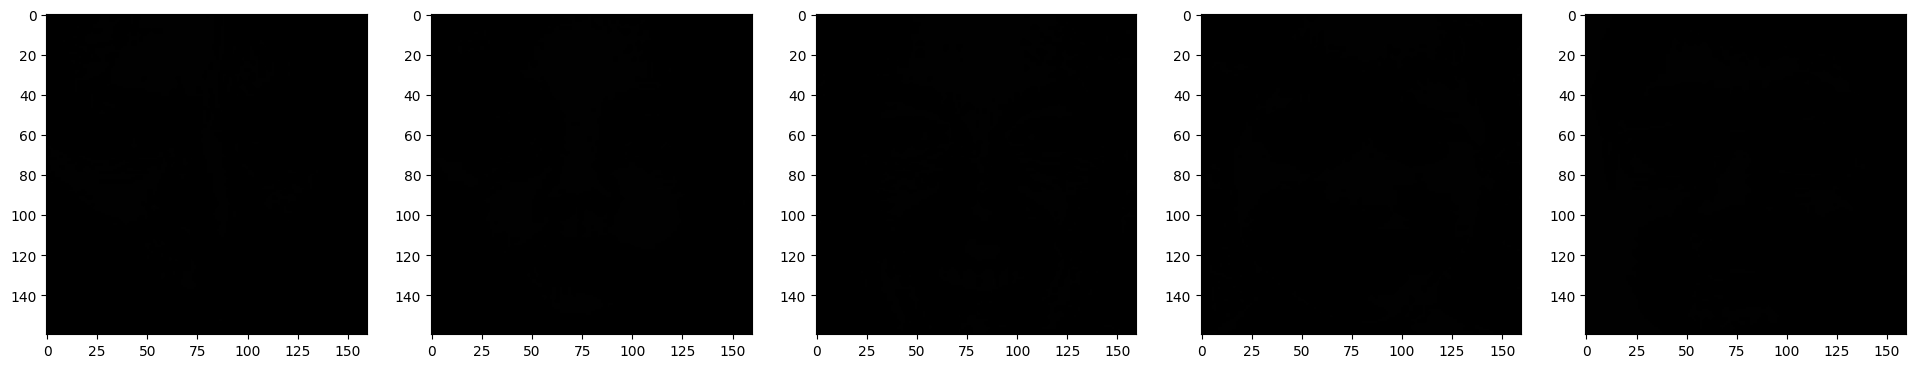

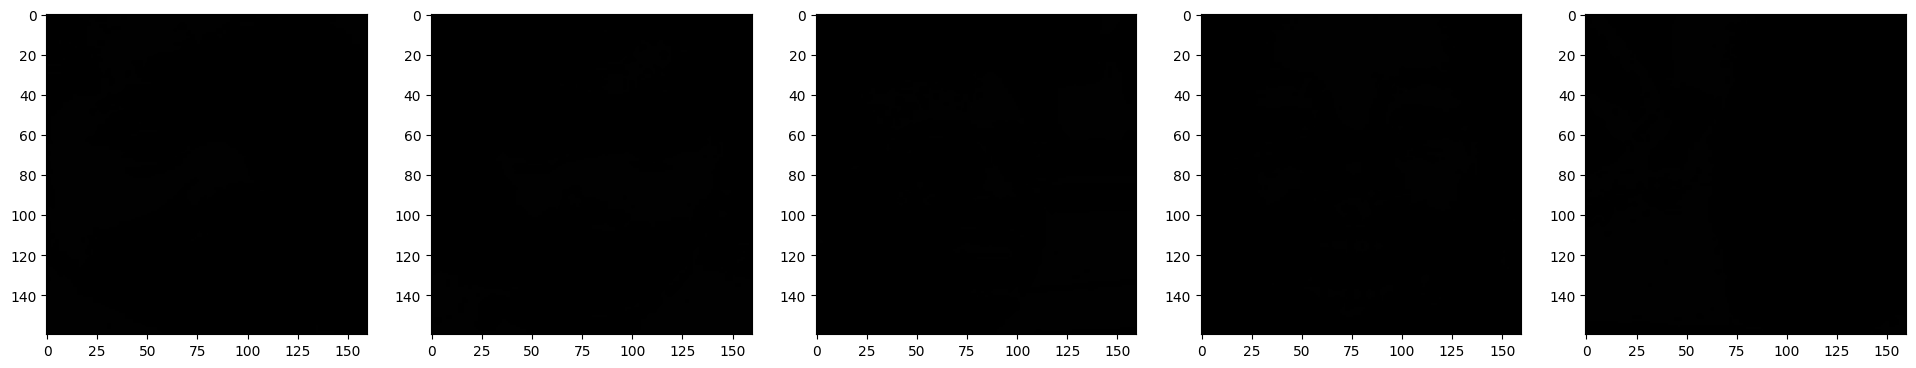

Features
(7238,)
(7238,)


In [14]:
# Deepface
# Available models ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model_deepface = DeepFace.build_model("Facenet")

target_size = (model_deepface.input_shape[0], model_deepface.input_shape[1])
dim = (int(target_size[0]), int(target_size[1]))

# Data location
folder = "data/roi_dataset"

# Counter for the number of classes in the dataset
nclasses = 0
# Counter for samples per class
nperclass = []
# Label for each class (name of the subfolder)
classlabels = []
# Initialize data structures and their corresponding labels
X = []
Y = []
XFaceNet = []

# Default resolution value for matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Number of sample images from each class to show
nims2show = 5

# Assumes that there is a subfolder per class in the given path
for class_name in os.listdir(folder):
    # Each subfolder implies one more class
    nclasses += 1
    # Initially, this class has no samples
    nsamples = 0

    # Compose the path
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Assumes images are in jpg format
        if file_name.endswith('.jpg'):
            # Read the image
            image = cv2.imread(os.path.join(class_folder, file_name))
            
            # Extract sizes
            height, width, depth = image.shape
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X.append(gray.reshape(height * width))
            
            # Deepface with FaceNet
            # Get embeddings
            img_embedding = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            img_embedding = calc_embs(model_deepface, np.expand_dims(img_embedding, axis=0))
            XFaceNet.append(img_embedding[0])
                    
            # Add numerical label of the sample
            Y.append(nclasses - 1)
            
            # Show the first nims2show samples of each class
            if nsamples < nims2show:
                if nsamples == 0:
                    figsize = 15 * width / float(dpi), 15 * height / float(dpi)
                    fig = plt.figure(figsize=figsize)
                
                fig.add_subplot(1, nims2show, nsamples + 1)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
            
            # Increase the number of samples
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
# Convert X and Y to numpy arrays
Y = np.array(Y, dtype='float64')
XFaceNet = np.array(XFaceNet, dtype='float32')

# Show information about the read dataset
# Debugging
print("Features")
print(XFaceNet.shape)
print(Y.shape)
# Get number of samples and features
# Get names of the classes
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

In [15]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

# Store file paths
file_paths = []
for class_name in os.listdir(folder):
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith('.jpg'):
            file_paths.append(os.path.join(class_folder, file_name))

folds = [[] for _ in range(5)]

fold = 1
for train_index, test_index in skf.split(X, Y):
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    
    fold_files = [file_paths[i] for i in test_index]
    folds[fold - 1] = fold_files
    
    fold += 1

# Save file paths to a file
with open('folds.txt', 'w') as f:
    for i, fold_files in enumerate(folds):
        f.write(f"Files in fold {i + 1}:\n")
        for file_path in fold_files:
            f.write(file_path + '\n')
        f.write('\n')

# Folds are also saved in the variable 'folds'

Fold 1
# samples in training set 5790
# samples in test set 1448
Fold 2
# samples in training set 5790
# samples in test set 1448
Fold 3
# samples in training set 5790
# samples in test set 1448
Fold 4
# samples in training set 5791
# samples in test set 1447
Fold 5
# samples in training set 5791
# samples in test set 1447


In [16]:
# Analyze images. Save imagepath to another file if no face found. Summarize results
analysis_results = []
failed_images = []

for i, fold_files in enumerate(folds):
    fold_results = defaultdict(lambda: defaultdict(int))
    for file_path in fold_files:
        try:
            objs = DeepFace.analyze(img_path=file_path, actions=['age', 'gender', 'race', 'emotion'])
            for obj in objs:  # iterate through the list of analysis results
                for key, value in obj.items():
                    if key in ['age', 'gender', 'race', 'emotion']:
                        if isinstance(value, dict):  # e.g., emotion analysis returns a dictionary
                            for sub_key, sub_value in value.items():
                                fold_results[key][sub_key] += sub_value
                        else:
                            fold_results[key][value] += 1
        except ValueError as e:
            print(f"Failed to analyze {file_path}: {e}")
            failed_images.append(file_path)
    analysis_results.append(fold_results)

# Save analysis results to a file
with open('analysis_summary.txt', 'w') as f:
    for i, fold_results in enumerate(analysis_results):
        f.write(f"Summary for fold {i + 1}:\n")
        for key, value in fold_results.items():
            f.write(f"{key}:\n")
            for sub_key, sub_value in value.items():
                f.write(f"  {sub_key}: {sub_value}\n")
        f.write('\n')

# Save failed images to a file
with open('failed_images.txt', 'w') as f:
    f.write("Images where face detection failed:\n")
    for file_path in failed_images:
        f.write(file_path + '\n')

# Print analysis results (optional)
for i, fold_results in enumerate(analysis_results):
    print(f"Summary for fold {i + 1}:")
    for key, value in fold_results.items():
        print(f"{key}:")
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    print('\n')

# Print failed images (optional)
print("Images where face detection failed:")
for file_path in failed_images:
    print(file_path)

Failed to analyze data/roi_dataset\fake\1003_faces.jpg: Face could not be detected in data/roi_dataset\fake\1003_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\1006_faces.jpg: Face could not be detected in data/roi_dataset\fake\1006_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\1009_faces.jpg: Face could not be detected in data/roi_dataset\fake\1009_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\100_faces.jpg: Face could not be detected in data/roi_dataset\fake\100_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\1013_faces.jpg: Face could not be detected in data/roi_dataset\fak

Action: emotion: 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]


Failed to analyze data/roi_dataset\real\7022_faces.jpg: Face could not be detected in data/roi_dataset\real\7022_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7029_faces.jpg: Face could not be detected in data/roi_dataset\real\7029_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7034_faces.jpg: Face could not be detected in data/roi_dataset\real\7034_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7038_faces.jpg: Face could not be detected in data/roi_dataset\real\7038_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7044_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Failed to analyze data/roi_dataset\real\7066_faces.jpg: Face could not be detected in data/roi_dataset\real\7066_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7076_faces.jpg: Face could not be detected in data/roi_dataset\real\7076_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7079_faces.jpg: Face could not be detected in data/roi_dataset\real\7079_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7087_faces.jpg: Face could not be detected in data/roi_dataset\real\7087_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Failed to analyze data/roi_dataset\real\7101_faces.jpg: Face could not be detected in data/roi_dataset\real\7101_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7107_faces.jpg: Face could not be detected in data/roi_dataset\real\7107_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7109_faces.jpg: Face could not be detected in data/roi_dataset\real\7109_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7122_faces.jpg: Face could not be detected in data/roi_dataset\real\7122_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7126_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


Failed to analyze data/roi_dataset\real\7223_faces.jpg: Face could not be detected in data/roi_dataset\real\7223_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7224_faces.jpg: Face could not be detected in data/roi_dataset\real\7224_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7225_faces.jpg: Face could not be detected in data/roi_dataset\real\7225_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\1014_faces.jpg: Face could not be detected in data/roi_dataset\fake\1014_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\1023_faces.jpg: Face could not be detected in data/roi_dataset\f

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]


Failed to analyze data/roi_dataset\real\7200_faces.jpg: Face could not be detected in data/roi_dataset\real\7200_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7216_faces.jpg: Face could not be detected in data/roi_dataset\real\7216_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7220_faces.jpg: Face could not be detected in data/roi_dataset\real\7220_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7227_faces.jpg: Face could not be detected in data/roi_dataset\real\7227_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\0_faces.jpg: Face could not be detected in data/roi_dataset\fake

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Failed to analyze data/roi_dataset\real\7053_faces.jpg: Face could not be detected in data/roi_dataset\real\7053_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7055_faces.jpg: Face could not be detected in data/roi_dataset\real\7055_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7056_faces.jpg: Face could not be detected in data/roi_dataset\real\7056_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7058_faces.jpg: Face could not be detected in data/roi_dataset\real\7058_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7061_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Failed to analyze data/roi_dataset\real\7060_faces.jpg: Face could not be detected in data/roi_dataset\real\7060_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7065_faces.jpg: Face could not be detected in data/roi_dataset\real\7065_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7067_faces.jpg: Face could not be detected in data/roi_dataset\real\7067_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7069_faces.jpg: Face could not be detected in data/roi_dataset\real\7069_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7071_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Failed to analyze data/roi_dataset\real\7080_faces.jpg: Face could not be detected in data/roi_dataset\real\7080_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7083_faces.jpg: Face could not be detected in data/roi_dataset\real\7083_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7092_faces.jpg: Face could not be detected in data/roi_dataset\real\7092_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7096_faces.jpg: Face could not be detected in data/roi_dataset\real\7096_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7103_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Failed to analyze data/roi_dataset\real\7105_faces.jpg: Face could not be detected in data/roi_dataset\real\7105_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7114_faces.jpg: Face could not be detected in data/roi_dataset\real\7114_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7115_faces.jpg: Face could not be detected in data/roi_dataset\real\7115_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7118_faces.jpg: Face could not be detected in data/roi_dataset\real\7118_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.18it/s]


Failed to analyze data/roi_dataset\real\7127_faces.jpg: Face could not be detected in data/roi_dataset\real\7127_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7129_faces.jpg: Face could not be detected in data/roi_dataset\real\7129_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7132_faces.jpg: Face could not be detected in data/roi_dataset\real\7132_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7134_faces.jpg: Face could not be detected in data/roi_dataset\real\7134_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7136_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]


Failed to analyze data/roi_dataset\real\7160_faces.jpg: Face could not be detected in data/roi_dataset\real\7160_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7165_faces.jpg: Face could not be detected in data/roi_dataset\real\7165_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7166_faces.jpg: Face could not be detected in data/roi_dataset\real\7166_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7182_faces.jpg: Face could not be detected in data/roi_dataset\real\7182_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7195_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]


Failed to analyze data/roi_dataset\fake\3506_faces.jpg: Face could not be detected in data/roi_dataset\fake\3506_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\3508_faces.jpg: Face could not be detected in data/roi_dataset\fake\3508_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\350_faces.jpg: Face could not be detected in data/roi_dataset\fake\350_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\351_faces.jpg: Face could not be detected in data/roi_dataset\fake\351_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\fake\352_faces.jpg: Face could not be detected in data/roi_dataset\fake\3

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Failed to analyze data/roi_dataset\real\7035_faces.jpg: Face could not be detected in data/roi_dataset\real\7035_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7045_faces.jpg: Face could not be detected in data/roi_dataset\real\7045_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7046_faces.jpg: Face could not be detected in data/roi_dataset\real\7046_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7059_faces.jpg: Face could not be detected in data/roi_dataset\real\7059_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Failed to analyze data/roi_dataset\real\7064_faces.jpg: Face could not be detected in data/roi_dataset\real\7064_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7072_faces.jpg: Face could not be detected in data/roi_dataset\real\7072_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7082_faces.jpg: Face could not be detected in data/roi_dataset\real\7082_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7085_faces.jpg: Face could not be detected in data/roi_dataset\real\7085_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7086_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Failed to analyze data/roi_dataset\real\7120_faces.jpg: Face could not be detected in data/roi_dataset\real\7120_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7161_faces.jpg: Face could not be detected in data/roi_dataset\real\7161_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7163_faces.jpg: Face could not be detected in data/roi_dataset\real\7163_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7168_faces.jpg: Face could not be detected in data/roi_dataset\real\7168_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7169_faces.jpg: Face could not be detected in data/roi_dataset\r

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

Failed to analyze data/roi_dataset\real\7178_faces.jpg: Face could not be detected in data/roi_dataset\real\7178_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7183_faces.jpg: Face could not be detected in data/roi_dataset\real\7183_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7188_faces.jpg: Face could not be detected in data/roi_dataset\real\7188_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7191_faces.jpg: Face could not be detected in data/roi_dataset\real\7191_faces.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
Failed to analyze data/roi_dataset\real\7192_faces.jpg: Face could not be detected in data/roi_dataset\r

In [17]:
print("+++++++++++++++++++++++++++++++++++++++++++\n")

# KNN 
precs_facenet_svm, recs_facenet_svm, acc_facenet_svm = [], [], []

precs_facenet_rf, recs_facenet_rf, acc_facenet_rf = [], [], []


SVM = SVC(kernel='rbf', class_weight='balanced')
SVM_parameters = {
    'C': [1e3, 5e3],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
}

RF = RandomForestClassifier()
RF_parameters = {
    'n_estimators': [100, 150, 200],
}

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("*********************\nFold %d" % fold)
        
    #Facenet - SVM
    print("\nDeepface/Facenet")
    XFaceNet=XFaceNet.reshape(-1, 1)
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index],Y[train_index], Y[test_index], SVM, SVM_parameters)
    print("\nDeepface/Facenet + SVM Metrics")
    precs_facenet_svm.append(precision_score(y_test, y_pred))
    recs_facenet_svm.append(recall_score(y_test, y_pred))
    acc_facenet_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    if fold == 1:
        print("Confussion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
        
    #Facenet - Random Forest
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index],Y[train_index], Y[test_index], RF, RF_parameters)
    print("\nDeepface/Facenet + RF Metrics")
    precs_facenet_rf.append(precision_score(y_test, y_pred))
    recs_facenet_rf.append(recall_score(y_test, y_pred))
    acc_facenet_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    if fold == 1:
        print("Confussion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes))) 
    fold += 1

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 35.000s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.450s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.51      0.58      0.54       703
        real       0.55      0.48      0.51       745

    accuracy                           0.53      1448
   macro avg       0.53      0.53      0.53      1448
weighted avg       0.53      0.53      0.53      1448

Confussion matrix:
[[407 296]
 [389 356]]
RandomForestClassifier training...
done in 20.392s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.024s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.46      0.47       703
        real       0.52      0.54      0.53       745

    accuracy               